In [1]:
import pandas as pd
import numpy as np
import time

from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import torch
import transformers 
from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anshilina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Исследовательский анализ данных

Чтобы не тратить время на прогон кода, можно загрузить сразу предобработанный файл `df_new.csv`. В начале обучения моделей.

In [2]:
df = pd.read_excel('/Users/anshilina/Downloads/patients_data.xlsx')

In [3]:
df.columns = ['admittion', 'discharge', 'sex', 'height', 'weight', 'bmi', 'bsa', 'birth',
              'age', 'total_operations', 'before_operations', 'redo', 'diagnosis', 'mkb', 'accomp_ill',
              'medication_main', 'medications_taken', 'eho', 'ekg', 'akg', 'kt', 'first_operation',
              'operation_date', 'date_of_oper', 'target']

df['id'] = df.index

Переведем дату к одному формату.

In [4]:
def date_parser(series):
    if '-' in str(series):
        return pd.to_datetime(series, format='%Y-%m-%d')
    else:
        return pd.to_datetime(series, format='%d.%m.%Y')

In [5]:
dates = ['admittion', 'discharge', 'birth', 'date_of_oper']

for col in dates:
    df[col] = df[col].apply(date_parser)

Сгенерим переменные `age` и `days_in_hospital` (количество дней до выписки). Преобразуем переменные `sex` и `redo`.

In [6]:
df['age'] = (df['date_of_oper'] - df['birth']).dt.days / 30
df['days_in_hospital'] = (df['discharge'] - df['admittion']).dt.days
df['sex'] = df['sex'].apply(lambda row: 1 if row == 'm' else 0)
df['redo'] = df['redo'].apply(lambda row: 0 if row == ' ' else 1)

In [7]:
df.describe()

,sex,height,weight,bmi,bsa,age,redo,target,id,days_in_hospital
count,300.000000,300.000000,300.000000,298.000000,298.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.546667,64.890000,6.293560,76.834430,0.336477,6.817556,0.263333,0.046667,149.500000,14.840000
std,0.498649,8.076012,1.951695,20.640196,0.073846,3.617584,0.441178,0.211276,86.746758,9.133774
min,0.000000,39.000000,1.270000,20.340000,0.120000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,60.000000,4.868500,62.007500,0.280000,4.033333,0.000000,0.000000,74.750000,9.000000
50%,1.000000,65.500000,6.442500,78.430000,0.350000,7.200000,0.000000,0.000000,149.500000,13.000000
75%,1.000000,71.000000,7.651250,91.797500,0.390000,10.008333,1.000000,0.000000,224.250000,18.000000
max,1.000000,85.000000,12.000000,137.650000,0.520000,12.200000,1.000000,1.000000,299.000000,60.000000


In [460]:
# fig, axs = plt.subplots(3, 2, figsize=(20,14))
# axs = axs.ravel()
# vals = ['height', 'weight', 'bmi', 'bsa', 'age', 'days_in_hospital']

# for i in range(len(vals)):
#     ax = axs[i]
#     sns.histplot(ax=ax, data=df, x=df[vals[i]], bins=30)
#     ax.set_title(vals[i])
    
# fig.tight_layout()

In [461]:
# fig, axs = plt.subplots(1, 2, figsize=(10,5))
# axs = axs.ravel()
# vals = ['sex', 'redo']

# for i in range(len(vals)):
#     ax = axs[i]
#     sns.barplot(ax=ax, data=df, 
#                 x=df[vals[i]].value_counts().index,
#                 y=df[vals[i]].value_counts().values)
#     ax.set_title(vals[i])
    
# fig.tight_layout()

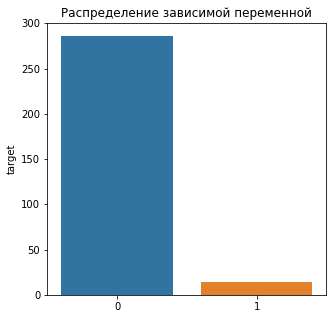

In [8]:
plt.figure(figsize=(5, 5))
sns.barplot(x=df['target'].value_counts().index,
            y=df['target'].value_counts())
plt.title('Распределение зависимой переменной')
plt.show()

In [9]:
df.isna().sum()

admittion              0
discharge              0
sex                    0
height                 0
weight                 0
bmi                    2
bsa                    2
birth                  0
age                    0
total_operations       0
before_operations      0
redo                   0
diagnosis              0
mkb                    0
accomp_ill             0
medication_main       47
medications_taken    120
eho                    7
ekg                   20
akg                  209
kt                   262
first_operation        0
operation_date         0
date_of_oper           0
target                 0
id                     0
days_in_hospital       0
dtype: int64

Удалим наблюдения с пропусками в переменных `bsa` и `bmi`, т.к. для этих наблюдений отсуствует как значение `bsa`, так и значение `bmi`.

In [10]:
# df.loc[df['bsa'].isna()]
# df.loc[df['bmi'].isna()]
# df.fillna('отсутсвует', inplace=True)

df.dropna(subset=['bsa', 'bmi'], inplace=True)

Обработаем текстовые переменные. Почистим текст, удалив всё кроме букв и цифр с помощью регулярных выражений.

In [11]:
text_cols = df.select_dtypes('object').columns.values
df[text_cols] = df[text_cols].values.astype('U')

## ЭХОКГ

In [12]:
eho = df[['id', 'eho']].copy()

In [13]:
eho['eho'] = eho['eho'].str.lower().replace(r'[^а-яё0-9.]', ' ', regex=True)

In [14]:
# Работаю с информацией до "заключения" врача
eho['eho'] = eho['eho'].str.extract(r'(.+?)заключение').fillna('').astype('str')

In [15]:
# Фракцией выброса (ФВ) именуется процент от объема крови
eho['fv'] = eho['eho'].str.extract(r'фв *(\d*)').fillna('-1').astype('str')
eho.loc[eho['fv']=='', 'fv'] = -1
eho['fv'] = eho['fv'].astype('int')

In [16]:
# Опечатка
eho.loc[eho['fv'] == 790, 'fv'] = 79

In [17]:
# Конечный диастолический размер (КДР) левого желудочка
res = eho['eho'].str.extract(r'((лж|левый желудочек).+?кдр *\d(.| )\d)').fillna('-1').astype('str')
res2 = eho['eho'].str.extract(r'(кдр лж *\d(.| )\d)').fillna('-1').astype('str')[0]
res[1] = res2
res = res[0] + res[1]

In [18]:
eho['lg_kdr_size'] = (res.str.extract(r'((кдр |кдр лж) *(\d( |.)\d))')[2]
                      .str.replace(' ', '.', regex=True)
                      .fillna('-1').astype('float'))

In [19]:
# Гипоплазия левого желудочка
res = eho['eho'].str.extract('((лж|левый желудочек|левые отделы сердца) .+ гипоплазирован(|ы))')[0].fillna('').astype('str')
eho['lg_hipoplaz'] = res.map(lambda x: 1 if 'гипоплаз' in x else 0)

In [107]:
# Конечный диастолический размер (КДР) правого желудочка
res = eho['eho'].str.extract(r'((пж|правые отделы сердца|правый желудочек).+?увел)').fillna('-1').astype('str')
eho['pg_big'] = res[0].map(lambda x: -1 if x == '-1' else 0 if 'не увел' in x else 1)

In [108]:
# Гипертрофия правого желудочка
res = eho['eho'].str.extract(r'((пж|правые отделы сердца|правый желудочек).+?гипертр)').fillna('-1').astype('str')
eho['pg_hypertrop'] = res[0].map(lambda x: 1 if 'гиперт' in x else 0)

In [170]:
# Дефект межжелудочковой перегородки (ДМЖП)
res = eho['eho'].str.extract(r'(дмжп.+? \d+ мм)').fillna('').astype('str')
eho['dmgp'] = res[0].str.extract(r'[а-я. ]*(\d*)').replace('', 0, regex=True).astype('int')

In [182]:
# Конечный диастолический объем (КДО)
res = eho['eho'].str.extract(r'(кдо.+?(\d*) мл)').fillna('-1').astype('str')[1]
eho['kdo'] = res.astype('int')

In [185]:
# Описание створок клапана
eho['flap'] = eho['eho'].str.extract(r'(створки.+?)фк').fillna('').astype('str')

In [186]:
eho = eho.fillna(0).drop('eho', axis=1)

In [187]:
eho

,id,fv,lg_kdr_size,lg_hipoplaz,pg_big,pg_hypertrop,dmgp,kdo,flap
0,0,70,2.1,0,-1,0,11,-1,створки тонкие. раскрытие полное
1,1,68,2.0,0,1,0,11,42,створки тонкие
2,2,70,2.6,0,1,0,12,-1,створки незначительно уплотнены раскрытие пол...
3,3,68,1.1,1,1,0,6,-1,створки подвижные. кровоток ограничен.
4,4,70,2.5,0,0,1,0,-1,створки утолщены удлинены диаметр отверстия ...
...,...,...,...,...,...,...,...,...,...
295,295,68,2.1,0,1,0,0,-1,створки подвижны. крпеление хорд через волж.
296,296,70,1.7,0,1,0,9,-1,
297,297,-1,-1.0,1,1,0,1,30,
298,298,70,2.0,0,1,0,10,-1,створки уплотнены сращены


## ЭКГ

Из тетрадки Татьяны.

In [68]:
ekg = df[['id', 'ekg']].copy()

In [69]:
ekg['ekg'] = ekg['ekg'].str.lower()

In [71]:
ekg['ekg_date'] = ekg['ekg'].str.extract(r'(\d+\.\d+\.\d{2,4})')

In [72]:
ekg['ekg_sinus'] = ekg['ekg'].str.extract(r'( синус)').notna().astype('int')

In [73]:
list_of_ss = '|'.join(['чсс', 'сердцебиений в минуту', 'сердечных сокращений'])
res = ekg['ekg'].str.extract(f'({list_of_ss}) ?=?-? ?(\d+)')[1]

In [85]:
eos_dict = {'прав': 1,
            'лев': 2,
            'норм':3, 
            'гориз':4, 
            'верт':5}

def ekg_replace(data):
    res = [eos_dict.get(x) for x in eos_dict.keys() if x in data]
    if res:
        return res[0]
    return 0

In [88]:
list_of_eos = '|'.join(['эос', 'электрической оси сердца:', 'ось сердца', 'ось'])
res = ekg['ekg'].str.extract(f'(({list_of_eos}) (отклонена)? ?(\w+))|((\w+) (положение э))')
res[3] = res[3].fillna(res[5])
ekg['ekg_eos'] = res[3]
ekg['ekg_eos'] = ekg['ekg_eos'].fillna(' ')
ekg['ekg_eos'] = ekg['ekg_eos'].map(ekg_replace)

In [115]:
ekg['ekg_qrs'] = ekg['ekg'].str.extract('(qrs) ?=?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_qrst'] = ekg['ekg'].str.extract('(qrst) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_pq'] = ekg['ekg'].str.extract('(pq) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')

In [116]:
ekg = ekg.fillna(0).drop('ekg', axis=1)

In [117]:
ekg.head()

,id,ekg_date,ekg_sinus,ekg_eos,ekg_qrs,ekg_qrst,ekg_pq
0,0,02.12.2016,1,1,0.07,0.26,0.12
1,1,13.01.2017,1,3,0.06,0.00,0.12
2,2,17.01.2017,1,1,0.00,0.00,0.00
3,3,0,1,2,0.00,0.00,0.00
4,4,14.02.17,1,1,0.00,0.00,0.00


## Количество исследований

In [618]:
analysis_count = df[['eho', 'ekg', 'akg', 'kt']].copy()

In [645]:
analysis_count['eho_count'] = (analysis_count['eho']
                               .fillna(0)
                               .map(lambda x: 0 if not x else 1))

analysis_count['ekg_count'] = (analysis_count['ekg']
                               .fillna(0)
                               .map(lambda x: 0 if not x else 1))

analysis_count['akg_count'] = (analysis_count['akg']
                               .fillna(0)
                               .map(lambda x: 0 if not x else 1))

analysis_count['kt_count'] = (analysis_count['kt']
                              .fillna(0)
                              .map(lambda x: 0 if not x else 1))

In [651]:
analysis_count['total'] = sum([analysis_count['kt_count'], analysis_count['akg_count'], 
                               analysis_count['ekg_count'], analysis_count['eho_count']]) 

In [653]:
analysis_count['total'].value_counts()

2    171
3    106
1     10
4      8
0      5
Name: total, dtype: int64

## Медикаменты, диагноз, мкб

Предстоит переделать.

In [589]:
def re_preprocessing_rus(series):
    clean_data = ' '.join(re.sub(r'[^а-яА-Я0-9 ]', ' ', series.lower()).split())
    return clean_data

In [590]:
def re_preprocessing_eng(series):
    cleaned_data = re.sub(r'[^а-яА-Яa-zA-ZёЁ0-9. ]', ' ', series.lower())
    cleaned_data = cleaned_data.split()
    return ' '.join(cleaned_data)

In [38]:
df['medication'] = df['medication'].apply(re_preprocessing_rus)
df['medications_taken'] = df['medications_taken'].apply(re_preprocessing_rus)
df['diagnosis'] = df['diagnosis'].apply(re_preprocessing_rus)
df['mkb'] = df['mkb'].apply(re_preprocessing_eng)


# df['first_operation'] = df['first_operation'].apply(re_preprocessing_rus)
# df['accomp_ill'] = df['accomp_ill'].apply(re_preprocessing_rus)
# df['accomp_ill'] = df['accomp_ill'].apply(lambda series: 'отсутсвует' if series == '' else series)

Лемматизируем токены в диагнозе.

In [40]:
%%time
df['diagnosis'] = df['diagnosis'].apply(lambda series: ''.join(Mystem().lemmatize(series)))

CPU times: user 332 ms, sys: 3.99 s, total: 4.32 s
Wall time: 5min 31s


In [39]:
# %%time
# df['first_operation'] = df['first_operation'].apply(lambda series: ''.join(Mystem().lemmatize(series)))

# %%time
# df['accomp_ill'] = df['accomp_ill'].apply(lambda series: ''.join(Mystem().lemmatize(series)))

Оставим в выборке только 12 признаков. В будущем необходимо выбрать способ кодирования текстовых признаков. Можно попробовать найти дообученный на мед. текстах BERT.

In [41]:
# df.drop(['birth', 'дата опер.', 'date_of_oper', 
#          'admittion', 'discharge', 'диагноз', 'мкб',
#          'медикам. леч. по поводу осн. забол. (из анамн.)',
#          'принимаемые препараты (из анамн.)',
#          'соп. забол. (из анамн.)',
#          'операция (основная / первая в иб)',
#          'операции (все в иб)',
#          'перенесенные опер. (из анамн.)',
#          'эхокг (из эпикр. до опер.)',
#          'экг (из эпикр. до опер.)', 
#          'акг (из эпикр. до опер.)', 
#          'кт (из эпикр. до опер.)'], 
#         axis=1, inplace=True)

In [43]:
# df.to_csv('new_df.csv', index=False)

### BERT

Не дообученный берт не помог улучшить качество.

In [106]:
# import torch
# import transformers 
# from tqdm import notebook
# import numpy as np

# df.reset_index(inplace=True, drop=True)

# tokenizer = transformers.BertTokenizer(vocab_file='/Users/anshilina/practicum/rubert/vocab.txt')

# tokenized = []
# for i in notebook.tqdm(range(df['diagnosis'].shape[0])):
#     tokenized.append(tokenizer.encode(df['diagnosis'][i], max_length=512, truncation=True, add_special_tokens=True))
    
# max_vector = max(len(token) for token in tokenized)
# padded = np.array([i + [0]*(max_vector - len(i)) for i in tokenized])
# attention_mask = np.where(padded != 0, 1, 0)

# config = transformers.BertConfig.from_json_file('/Users/anshilina/practicum/rubert/config.json')
# model = transformers.BertModel.from_pretrained('/Users/anshilina/practicum/rubert/pytorch_model.bin', config=config) 

# batch_size = 149
# embeddings = []

# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
    
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#     embeddings.append(batch_embeddings[0][:,0,:].numpy()) 
    
    
# diagnosis = pd.DataFrame(np.concatenate(embeddings))
# diagnosis.columns = [str(i) + 'emb' for i in diagnosis.columns]
# df = df.join(diagnosis)
# df.drop(['diagnosis', 'main_operation'], axis=1, inplace=True)

## Обучение моделей

In [193]:
# df = pd.read_csv('new_df.csv')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 299
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                298 non-null    int64  
 1   height             298 non-null    int64  
 2   weight             298 non-null    float64
 3   bmi                298 non-null    float64
 4   bsa                298 non-null    float64
 5   age                298 non-null    float64
 6   redo               298 non-null    int64  
 7   target             298 non-null    int64  
 8   days_in_hospital   298 non-null    int64  
 9   medication         298 non-null    object 
 10  medications_taken  298 non-null    object 
 11  diagnosis          298 non-null    object 
 12  icd                298 non-null    object 
dtypes: float64(4), int64(5), object(4)
memory usage: 32.6+ KB


Создадим пайплайны для предобаботки текстовых и числовых переменных. Для лиейных моделей будем скалировать числовые переменные, для деревянных – нет.

In [45]:
numerical = (df
             .drop('target', axis=1)
             .select_dtypes(include=['int', 'float'])
             .columns.values
)
num_pipe = Pipeline([('scaler', StandardScaler())])

stop_words = set(stopwords.words('russian')) 
categorical = (df
               .select_dtypes(include='object')
               .columns.values)


linear_preprocessor = ColumnTransformer(
    transformers = [(x, TfidfVectorizer(stop_words=stop_words), x) for x in categorical] + \
                   [('num', num_pipe, numerical)], 
    remainder='passthrough')


tree_preprocessor = ColumnTransformer(
    transformers = [(x, TfidfVectorizer(stop_words=stop_words), x) for x in categorical],
    remainder='passthrough')

Выборку разделим в соотношении 75:25. Используем стратификацию при разбиении. Также будем использовать `StratifiedKFold` при разбиении выборки на фолды на кросс-валидации.

In [46]:
features, target = df.drop('target', axis=1), df['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=0.25, random_state=42)

In [47]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Decision tree

In [83]:
baseline_clf = Pipeline([('preprocessor', tree_preprocessor),
                         # ('smote', SMOTE(random_state=42)),
                         # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                         # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                         # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                         ('svm', SVMSMOTE(random_state=42)),
                         ('model', DecisionTreeClassifier(class_weight='balanced',
                                                          random_state=42))])

baseline_grid = {'model__max_depth':[5,8,11]}

baseline_gs = GridSearchCV(baseline_clf, baseline_grid, 
                           scoring='f1', n_jobs=-1, 
                           cv=skf.split(features_train, target_train))

In [84]:
start = time.time()
baseline_gs.fit(features_train, target_train)
baseline_gs_time = time.time() - start

In [85]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(baseline_gs_time, 2)} сек')
print(f'Время обучения модели: {round(baseline_gs.cv_results_["mean_fit_time"][baseline_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(baseline_gs.cv_results_["mean_score_time"][baseline_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {baseline_gs.best_score_}')
print(f'Лучшие значения параметров: {baseline_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 0.3 сек
Время обучения модели: 0.05616 сек
Время предсказания модели: 0.0139 сек
Качество модели по кросс-валидации: 0.13333333333333333
Лучшие значения параметров: {'model__max_depth': 5}


### Logistic regression

In [86]:
lin_clf = Pipeline([('preprocessor', linear_preprocessor),
                    # ('smote', SMOTE(random_state=42)),
                    # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                    # ('smoteen', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                    # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                    ('svm', SVMSMOTE(random_state=42)),
                    ('model', LogisticRegression(class_weight='balanced',
                                                 solver='liblinear'))])

In [87]:
lin_grid = {'model__penalty': ['l1', 'l2'],
            'model__C' : range(1, 8)}

lin_gs = GridSearchCV(lin_clf, lin_grid, 
                      scoring='f1', n_jobs=-1, 
                      cv=skf.split(features_train, target_train))

In [88]:
start = time.time()
lin_gs.fit(features_train, target_train)
lin_gs_time = time.time() - start

In [89]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(lin_gs_time, 2)} сек')
print(f'Время обучения модели: {round(lin_gs.cv_results_["mean_fit_time"][lin_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(lin_gs.cv_results_["mean_score_time"][lin_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {lin_gs.best_score_}')
print(f'Лучшие значения параметров: {lin_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 1.22 сек
Время обучения модели: 0.0718 сек
Время предсказания модели: 0.01553 сек
Качество модели по кросс-валидации: 0.41666666666666663
Лучшие значения параметров: {'model__C': 1, 'model__penalty': 'l2'}


### Random forest

In [90]:
forest_clf = Pipeline([('preprocessor', tree_preprocessor),
                       # ('smote', SMOTE(random_state=42)),
                       # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                       # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                       # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                       ('svm', SVMSMOTE(random_state=42)),
                       ('model', RandomForestClassifier(class_weight='balanced',
                                                        random_state=42))])

In [91]:
forest_grid = {'model__max_depth':[4,5,8,10],
               'model__n_estimators': range(10, 50, 5)}

forest_gs = GridSearchCV(forest_clf, forest_grid, 
                         scoring='f1', n_jobs=-1, 
                         cv=skf.split(features_train, target_train))

In [92]:
start = time.time()
forest_gs.fit(features_train, target_train)
forest_gs_time = time.time() - start

In [93]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(forest_gs_time, 2)} сек')
print(f'Время обучения модели: {round(forest_gs.cv_results_["mean_fit_time"][forest_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(forest_gs.cv_results_["mean_score_time"][forest_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {forest_gs.best_score_}')
print(f'Лучшие значения параметров: {forest_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 3.77 сек
Время обучения модели: 0.07709 сек
Время предсказания модели: 0.01677 сек
Качество модели по кросс-валидации: 0.26666666666666666
Лучшие значения параметров: {'model__max_depth': 4, 'model__n_estimators': 15}


### Balanced forest

In [94]:
balanced_forest_clf = Pipeline([('preprocessor', tree_preprocessor),
                                # ('smote', SMOTE(random_state=42)),
                                # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                                # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),
                                # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                                ('svm', SVMSMOTE(random_state=42)),
                                ('model', BalancedRandomForestClassifier(random_state=42, 
                                                                         class_weight='balanced',
                                                                         n_jobs=-1))])

In [95]:
balanced_forest_grid = {'model__max_depth':[4,5,8,10],
                        'model__n_estimators': range(10, 50, 5)}

balanced_forest_grid = GridSearchCV(balanced_forest_clf, balanced_forest_grid, 
                                    scoring='f1', n_jobs=-1, 
                                    cv=skf.split(features_train, target_train))

In [96]:
start = time.time()
balanced_forest_grid.fit(features_train, target_train)
balanced_forest_time = time.time() - start

In [97]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(balanced_forest_time, 2)} сек')
print(f'Время обучения модели: {round(balanced_forest_grid.cv_results_["mean_fit_time"][balanced_forest_grid.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(balanced_forest_grid.cv_results_["mean_score_time"][balanced_forest_grid.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {balanced_forest_grid.best_score_}')
print(f'Лучшие значения параметров: {balanced_forest_grid.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 7.08 сек
Время обучения модели: 0.09741 сек
Время предсказания модели: 0.02562 сек
Качество модели по кросс-валидации: 0.26666666666666666
Лучшие значения параметров: {'model__max_depth': 4, 'model__n_estimators': 10}


### Catboost

In [98]:
cat_clf = Pipeline([('preprocessor', tree_preprocessor),
                    # ('smote', SMOTE(random_state=42)),
                    # ('border_smote', BorderlineSMOTE(random_state=42, n_jobs=-1)),
                    # ('smote', SMOTEENN(smote=SMOTE(random_state=42, k_neighbors=3), random_state=42)),   
                    # ('adasyn', ADASYN(random_state=42, n_neighbors=3)),
                    ('svm', SVMSMOTE(random_state=42)),
                    ('model', CatBoostClassifier(class_weights=dict(zip(np.unique(target_train), 
                                                                        compute_class_weight(class_weight='balanced', 
                                                                                             classes=np.unique(target_train), 
                                                                                             y=target_train))), 
                                                 silent=True, random_seed=42))])

In [100]:
cat_grid = {'model__depth':[5,8,10],
            'model__iterations': [100, 150, 200]} 

cat_gs = GridSearchCV(cat_clf, cat_grid, 
                      scoring='f1', n_jobs=-1, 
                      cv=skf.split(features_train, target_train))

In [101]:
start = time.time()
cat_gs.fit(features_train, target_train)
cat_gs_time = time.time() - start

In [102]:
print('Результаты подбора параметров.\n')
print(f'Время подбора параметров: {round(cat_gs_time // 60, 2)} мин')
print(f'Время обучения модели: {round(cat_gs.cv_results_["mean_fit_time"][cat_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(cat_gs.cv_results_["mean_score_time"][cat_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {cat_gs.best_score_}')
print(f'Лучшие значения параметров: {cat_gs.best_params_}')

Результаты подбора параметров.

Время подбора параметров: 3.0 мин
Время обучения модели: 42.5123 сек
Время предсказания модели: 0.24694 сек
Качество модели по кросс-валидации: 0.3333333333333333
Лучшие значения параметров: {'model__depth': 8, 'model__iterations': 200}


## Вывод 

Используем модель СatBoost. Стратегия `SMOTE` позволяет лучше определять 1 класс, а стратегия `SVMSMOTE` показывает лучшее качество, но относительно 1 класса ошибается в половине случаев.

## Качество на тесте

In [109]:
print(classification_report(target_test, cat_gs.predict(features_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.67      0.50      0.57         4

    accuracy                           0.96        75
   macro avg       0.82      0.74      0.78        75
weighted avg       0.96      0.96      0.96        75



In [104]:
print(classification_report_imbalanced(target_test, cat_gs.predict(features_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.99      0.50      0.98      0.70      0.52        71
          1       0.67      0.50      0.99      0.57      0.70      0.47         4

avg / total       0.96      0.96      0.53      0.96      0.70      0.51        75



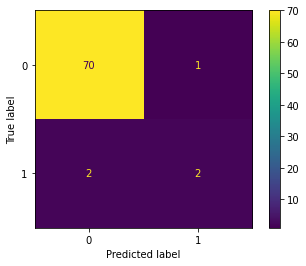

In [107]:
ConfusionMatrixDisplay(confusion_matrix(target_test,  cat_gs.predict(features_test))).plot();

## Задачи

* Найти решение для предобработки текстовых данных. Рассмотреть возможность дообучить BERT
* Провести корреляционный анализ
* Продолжить поиск решений для работы с несбалансированной выборкой
* Рассмотреть другие варианты моделей